# 自动化计划属性组合
* <font color=red>目的</font>：结合新素材评分，自动化新建计划各个属性的组合流程；
* <font color=red>已实现思路</font>：
* 1）概率随机初始化多条属性选项的计划，对其分别进行概率评分，然后组合账号、素材的对应关系，做阈值条件筛选；

* <font color=red>优化思路</font>：
* 1）决策树模型的逆向推理之根据目标值Y来反推特征X集合；   
   > 难点：没有具体代码实现，或者很难实现，因为确实非线性问题反推有无穷多解，即使实现了估计计算复杂度也不低
* 2）决策树模型的常规推理后，输出每一个结点的规则条件，然后按照整体规则逻辑，一步一步随机选择符合子节点子规则预期的条件取值；✔   
* 3）图神经网络Pointer Network，解决组合调度优化问题；   
   > 难点：更偏统筹/动态优化，而且涉及不同属性取值的先后关系，场景有点差异
* 4）概率采样 + 频繁项集 + roi或pay_rate排名靠前优质定向采样；✔

* <font color=red>用image_id</font>：表示特征字段利用了素材ID，但是新素材因为是全新的ID，所以不适用于新素材计划的概率评估

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
from impala.dbapi import connect
from impala.util import as_pandas
import gc
import json
import pymysql
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.auto import tqdm
tqdm.pandas(desc="Processing!")

from script.dtc_rule import tree_to_code

# from script.weight import weights_calcul, weights_assign  # 权值编、解码脚本

## 数据：计划信息+素材信息+运营指标信息
* 计划信息表：含有各计划创建的属性详情（有缺失）；
* 素材信息表：含有各素材的素材ID以及素材标签情况；
* 运营信息表：含有各计划上线跑分的指标情况，只用于后续打标签；

In [2]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

### 采集：计划信息

In [3]:
plan_info = pd.read_csv('/home/data/ch_data/ptom_third_plan.csv')

In [4]:
def get_plan_info():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)
    conn = pymysql.connect(host='192.168.0.65', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t', db='db_ptom')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
    /*手动查询*/
        SELECT
                * 
            FROM
                db_ptom.ptom_third_plan p
            WHERE
                game_id IN ({})
                AND media_id = 10
                AND create_time>='2020-01-01'
                AND create_time<= date(NOW())
                            AND plan_id >= (
                                select plan_id from db_ptom.ptom_plan
                                where create_time >= '2021-04-23'
                                and create_time <= '2021-04-24'
                                limit 1
                            )
    '''
    finalSql = sql.format(game_id)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    return result_df

In [5]:
plan_info_new = get_plan_info()

### 采集：素材信息

In [6]:
image_info = pd.read_csv('/home/data/ch_data/image_info.csv')

In [7]:
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id,
            a.image_id,
            b.label_ids
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN
            db_data_ptom.ptom_image_info b
        on a.image_id = b.image_id
        WHERE
            a.game_id IN ( SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL ) 
            AND a.media_id = 10 
            AND a.create_time >= '2020-01-01' 
        GROUP BY
            a.chl_user_id,
            a.source_id,
            a.image_id
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [8]:
image_info_new = get_image_info()

### 采集：运营信息

In [9]:
launch_report = pd.read_csv('/home/data/ch_data/launch_report.csv')

In [10]:
def get_launch_report():
    game_id = get_game_id()
    game_id = list(map(lambda x: x['game_id'], game_id))
    game_id = [str(i) for i in game_id]
    game_id = ','.join(game_id)

    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        /*手动查询*/
        SELECT
            a.chl_user_id AS channel_id,
            a.source_id AS source_id,
            b.tdate,
            b.amount,
            b.new_role_money,
            b.new_role_money / b.amount as roi,
            b.pay_role_user_num / b.create_role_num as pay_rate
        FROM
            db_data_ptom.ptom_plan a
            LEFT JOIN db_stdata.st_lauch_report b ON a.chl_user_id = b.channel_id 
            AND a.source_id = b.source_id 
        WHERE
            a.create_time >= '2020-01-01' 
            AND b.tdate >= '2020-01-01' 
            AND b.tdate_type = 'day' 
            AND b.media_id = 10
            AND b.game_id IN ({})
            AND b.amount >= 500
    '''
    finalSql = sql.format(game_id)
    cur.execute(finalSql)
    result_df = pd.read_sql(finalSql, conn)
    cur.close()
    conn.close()
    result_df['tdate'] = pd.to_datetime(result_df['tdate'])
    result_df = result_df.sort_values('tdate')
    result_df = result_df.drop_duplicates(['channel_id', 'source_id'], keep='first')

    return result_df

In [11]:
launch_report_new = get_launch_report()

### 采集附加：素材评分信息

In [12]:
# image_score = pd.read_csv('/home/data/ch_data/dws_image_score_d.csv', encoding='GB2312')

In [13]:
# image_score.dropna(subset=['image_id', 'score'], inplace=True)

In [14]:
# image_score = image_score[['image_id', 'model_run_datetime', 'score']]
# image_score.columns = ['image_id', 'create_time', 'image_score']
# image_score.drop_duplicates(inplace=True)

### 合并

In [15]:
def get_plan_json(plan_info):
    plan_info.drop(['inventory_type', 'budget'], axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info.dropna(subset=['ad_info'], inplace=True)
    # 解析json
    plan_info['ad_info'] = plan_info['ad_info'].apply(json.loads)
    temp = plan_info['ad_info'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('ad_info', axis=1, inplace=True)
    temp = plan_info['audience'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('audience', axis=1, inplace=True)
    temp = plan_info['action'].apply(pd.Series)
    plan_info = pd.concat([plan_info, temp], axis=1)
    plan_info.drop('action', axis=1, inplace=True)
    plan_info.dropna(how='all', inplace=True, axis=1)
    plan_info = plan_info[['ad_account_id', 'game_id', 'channel_id', 'source_id',
                           'create_time', 'smart_bid_type', 'hide_if_exists', 'budget',
                           'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted',
                           'flow_control_mode', 'schedule_time', 'cpa_bid', 'auto_extend_enabled',
                           'gender', 'city', 'platform', 'launch_price',
                           'retargeting_tags_exclude', 'interest_categories',
                           'ac', 'android_osv', 'location_type', 'retargeting_tags_include',
                           'retargeting_type', 'ios_osv', 'interest_action_mode', 'age',
                           'action_categories', 'action_days', 'action_scene', 'deep_bid_type']]
    return plan_info

In [16]:
# 计划
plan_info = plan_info.append(plan_info_new)
plan_info = get_plan_json(plan_info)
plan_info.dropna(subset=['cpa_bid'], inplace=True)
# 素材
image_info = image_info.append(image_info_new)
# image_info = pd.merge(image_info, image_score, on=['image_id'], how='inner')
image_info.dropna(subset=['image_id'], inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)
# 运营
launch_report = launch_report.append(launch_report_new)

* 拼接+过滤

In [17]:
df = pd.merge(plan_info, image_info, on=['channel_id', 'source_id'], how='left')
df.dropna(subset=['image_id'], inplace=True)
df = pd.merge(df, launch_report, on=['channel_id', 'source_id'], how='left')
df.drop(df[df['tdate'].isna()].index, inplace=True)
df = df[df['amount'] >= 500]

### 字段处理
* ROI指标打标签

In [18]:
df.dropna(subset=['roi'], inplace=True)
df.dropna(subset=['new_role_money'], inplace=True)
df.dropna(subset=['amount'], inplace=True)

In [19]:
df['platform'] = df['platform'].astype(str)
df['platform'] = df['platform'].map({"['ANDROID']": 1, "['IOS']": 2})
df['label'] = df.apply(lambda x: 1 if x.new_role_money / x.amount >= 0.01 or x.roi >= 0.01 else 0, axis=1)  # 打标签
df['ad_account_id'] = df['ad_account_id'].astype('int')
df['image_id'] = df['image_id'].astype('int')
df.rename(columns={'tdate': 'create_date'}, inplace=True)
df['create_date'] = pd.to_datetime(df['create_date'])
df['create_time'] = pd.to_datetime(df['create_time'])

In [20]:
df.drop(['channel_id', 'source_id', 'schedule_time', 'amount', 'roi', 'pay_rate', 'new_role_money'], axis=1, inplace=True)

#### 特殊字段

In [21]:
df = df.mask(df.applymap(str).eq('[]'))  # 空list替换为NaN

In [22]:
df = df.mask(df.applymap(str).eq('NONE'))  # NONE替换为NaN

#### 缺失统计
* 这里的缺失不代表取值不确定，而是没有条件定向的限制，所以不应该过滤

In [23]:
from matplotlib import pyplot as plt

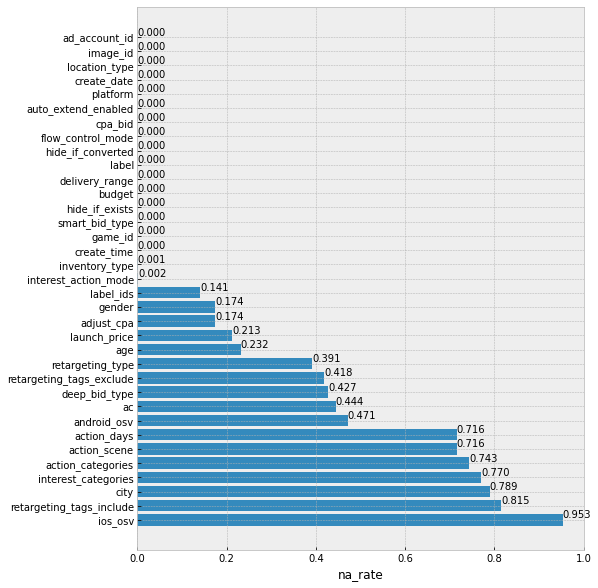

In [24]:
# 各字段缺失率统计
na_rate = (len(df) - df.count()) / len(df)  # 缺失率
a = na_rate.sort_values(ascending=False)  # 倒序
a1 = pd.DataFrame(a)
plt.style.use('bmh')
plt.figure(figsize = (8,10))
plt.barh(range(df.shape[1]),a1[0])
plt.xlabel('na_rate')
plt.xlim([0,1])
plt.yticks(range(df.shape[1]),a1.index.values.tolist())
for x,y in enumerate(a1[0]):
    plt.text(y,x,'%.3f'%y, va='bottom')

In [25]:
# df.drop(['schedule_time', 'ios_osv', 'retargeting_tags_include', 'city', 'interest_categories', 'action_categories', 'action_scene', 'action_days', 'android_osv', 'ac', 'retargeting_tags_exclude', 'deep_bid_type', 'retargeting_type'], axis=1, inplace=True)  # 删除缺失率超25%的字段
# df.drop_duplicates(inplace=True)  # keep=first

In [26]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155246 entries, 0 to 155245
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ad_account_id             155246 non-null  int64         
 1   game_id                   155246 non-null  int64         
 2   create_time               155246 non-null  datetime64[ns]
 3   smart_bid_type            155246 non-null  object        
 4   hide_if_exists            155246 non-null  int64         
 5   budget                    155246 non-null  float64       
 6   delivery_range            155246 non-null  object        
 7   adjust_cpa                128160 non-null  float64       
 8   inventory_type            155110 non-null  object        
 9   hide_if_converted         155246 non-null  object        
 10  flow_control_mode         155246 non-null  object        
 11  cpa_bid                   155246 non-null  float64       
 12  au

In [27]:
df.head()

,ad_account_id,game_id,create_time,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,inventory_type,hide_if_converted,flow_control_mode,cpa_bid,auto_extend_enabled,gender,city,platform,launch_price,retargeting_tags_exclude,interest_categories,ac,android_osv,location_type,retargeting_tags_include,retargeting_type,ios_osv,interest_action_mode,age,action_categories,action_days,action_scene,deep_bid_type,image_id,label_ids,create_date,label
0,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,NaN,2020-01-21,0
1,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,NaN,2020-01-21,0
2,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,None,2020-01-21,0
3,4003,1000840,2020-01-19 16:18:31,SMART_BID_CONSERVATIVE,0,5000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1135.73,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19788,None,2020-01-21,0
4,4003,1000840,2020-01-20 14:35:23,SMART_BID_CONSERVATIVE,0,8000.0,UNION,0.0,[INVENTORY_UNION_SLOT],AD,FLOW_CONTROL_MODE_FAST,1180.24,0,GENDER_MALE,NaN,1,NaN,NaN,NaN,NaN,NaN,CURRENT,NaN,NaN,NaN,UNLIMITED,"[AGE_BETWEEN_24_30, AGE_BETWEEN_31_40, AGE_BET...",NaN,NaN,NaN,NaN,19791,NaN,2020-01-20,0


## 特征工程
* 连续值标准化;
* 离散值2种方式;

### 离散值
* Embedding编码：list定向组合的特征

In [28]:
def get_mutil_feature(data):
    cols = ['inventory_type', 'age', 'label_ids', 'ac']
    for col in cols:
        data[col] = data[col].apply(lambda x: x if x == x else np.nan)
        data = data.join(data[col].str.join('|').str.get_dummies().add_prefix(col + '_').reset_index(drop=True))
        data.drop(col, axis=1, inplace=True)
    # gc.collect()
    return data

In [29]:
df = get_mutil_feature(df)

* 其他全部数字编码

In [30]:
cat_cols = ['ad_account_id', 'game_id', 'delivery_range', 'flow_control_mode','adjust_cpa',
            'smart_bid_type', 'hide_if_converted', 'gender', 'location_type', 'launch_price', 'retargeting_type',
            'android_osv', 'ios_osv', 'interest_action_mode', 'action_days', 'image_id','deep_bid_type']

In [31]:
for col in cat_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})
    frame = pd.DataFrame.from_dict(res, orient='index', columns=['values'])
    frame.to_csv("./tmp/{}.csv".format(col))

In [32]:
df = df.drop(['create_time', 'create_date', 'city', 'action_categories', 'action_scene', 'interest_categories', 'retargeting_tags_include', 'retargeting_tags_exclude'], axis=1)
# df = df[['cpa_bid', 'budget', 'image_id', 'label']]

In [33]:
df.reset_index(drop=True, inplace=True)
df.head()

,ad_account_id,game_id,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,cpa_bid,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,deep_bid_type,image_id,label,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_INVENTORY_FEED,inventory_type_INVENTORY_HOTSOON_FEED,inventory_type_INVENTORY_SEARCH,inventory_type_INVENTORY_TOMATO_NOVEL,inventory_type_INVENTORY_UNION_SLOT,inventory_type_INVENTORY_UNION_SPLASH_SLOT,inventory_type_INVENTORY_VIDEO_FEED,inventory_type_UNION_BOUTIQUE_GAME,age_AGE_ABOVE_50,age_AGE_BETWEEN_18_23,age_AGE_BETWEEN_24_30,age_AGE_BETWEEN_31_40,age_AGE_BETWEEN_41_49,"label_ids_,",label_ids_-,label_ids_0,label_ids_1,label_ids_2,label_ids_3,label_ids_4,label_ids_5,label_ids_6,label_ids_7,label_ids_8,label_ids_9,ac_2G,ac_3G,ac_4G,ac_WIFI
0,2,0,0,0,5000.0,1,0,0,1,1135.73,0,1,1,12,9,1,2,12,2,7,8,115,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,5000.0,1,0,0,1,1135.73,0,1,1,12,9,1,2,12,2,7,8,115,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,5000.0,1,0,0,1,1135.73,0,1,1,12,9,1,2,12,2,7,8,115,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,5000.0,1,0,0,1,1135.73,0,1,1,12,9,1,2,12,2,7,8,115,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,8000.0,1,0,0,1,1180.24,0,1,1,12,9,1,2,12,2,7,8,117,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# df['budget'].isnull().any()

### 去重

In [35]:
df.drop_duplicates(inplace=True)  # keep=first
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,ad_account_id,game_id,smart_bid_type,hide_if_exists,budget,delivery_range,adjust_cpa,hide_if_converted,flow_control_mode,cpa_bid,auto_extend_enabled,gender,platform,launch_price,android_osv,location_type,retargeting_type,ios_osv,interest_action_mode,action_days,deep_bid_type,image_id,label,inventory_type_INVENTORY_AWEME_FEED,inventory_type_INVENTORY_AWEME_SEARCH,inventory_type_INVENTORY_FEED,inventory_type_INVENTORY_HOTSOON_FEED,inventory_type_INVENTORY_SEARCH,inventory_type_INVENTORY_TOMATO_NOVEL,inventory_type_INVENTORY_UNION_SLOT,inventory_type_INVENTORY_UNION_SPLASH_SLOT,inventory_type_INVENTORY_VIDEO_FEED,inventory_type_UNION_BOUTIQUE_GAME,age_AGE_ABOVE_50,age_AGE_BETWEEN_18_23,age_AGE_BETWEEN_24_30,age_AGE_BETWEEN_31_40,age_AGE_BETWEEN_41_49,"label_ids_,",label_ids_-,label_ids_0,label_ids_1,label_ids_2,label_ids_3,label_ids_4,label_ids_5,label_ids_6,label_ids_7,label_ids_8,label_ids_9,ac_2G,ac_3G,ac_4G,ac_WIFI
0,2,0,0,0,5000.0,1,0,0,1,1135.73,0,1,1,12,9,1,2,12,2,7,8,115,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,8000.0,1,0,0,1,1180.24,0,1,1,12,9,1,2,12,2,7,8,117,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,10000.0,0,0,0,1,1377.89,0,1,1,12,9,1,2,12,2,7,8,92,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,10000.0,0,0,0,1,1431.96,0,1,1,12,9,1,2,12,2,7,8,130,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,10000.0,0,0,0,1,1484.64,0,1,1,12,9,1,2,12,2,7,8,92,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [36]:
print("数据量：", len(df))
df['label'].value_counts()

数据量： 44134


0    37470
1     6664
Name: label, dtype: int64

In [37]:
# df = pd.concat([df[df['label'] == 0].sample(len(df[df['label'] == 1])), df[df['label'] == 1]])  # 随机负采样,平衡正负样本

## 建模

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # 决策树模型
from xgboost import XGBClassifier  # XGB树模型集成
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn import tree
import xgboost
import pydotplus
from collections import Counter
from sklearn.metrics import classification_report

/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this wi

In [39]:
X = df.drop(['label'], axis=1)
Y = df['label']

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 2021, shuffle=True)
print([datas.shape for datas in [X_train, X_test, Y_train, Y_test]])

[(30893, 53), (13241, 53), (30893,), (13241,)]


In [41]:
print('训练集:', Counter(Y_train))
print('测试集:', Counter(Y_test))

训练集: Counter({0: 26299, 1: 4594})
测试集: Counter({0: 11171, 1: 2070})


In [42]:
MLA = [XGBClassifier(),   # 加权 scale_pos_weight=round(Counter(Y_train)[0] / (2 * Counter(Y_train)[1]), 2)
       RandomForestClassifier(),  # 加权 class_weight = dict({0:Counter(Y_train)[0], 1:Counter(Y_train)[1]})
       DecisionTreeClassifier()]  # 加权 class_weight = 'balanced'

### XGB

In [43]:
xgb_model = MLA[0]

In [44]:
xgb_model.fit(X_train, Y_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_test_pred = np.expand_dims(xgb_test_pred, axis=-1)

xgb_train_pred = xgb_model.predict(X_train)
xgb_train_pred = np.expand_dims(xgb_train_pred, axis=-1)

/root/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:20:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
y_true = Y_train
y_pred = xgb_train_pred
target_names = ['class 0', 'class 1']
print("训练集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

训练集效果:
             precision    recall  f1-score   support

    class 0       0.90      0.99      0.94     26299
    class 1       0.85      0.34      0.48      4594

avg / total       0.89      0.89      0.87     30893



In [46]:
y_true = Y_test
y_pred = xgb_test_pred
target_names = ['class 0', 'class 1']
print("测试集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

测试集效果:
             precision    recall  f1-score   support

    class 0       0.87      0.97      0.92     11171
    class 1       0.56      0.20      0.29      2070

avg / total       0.82      0.85      0.82     13241



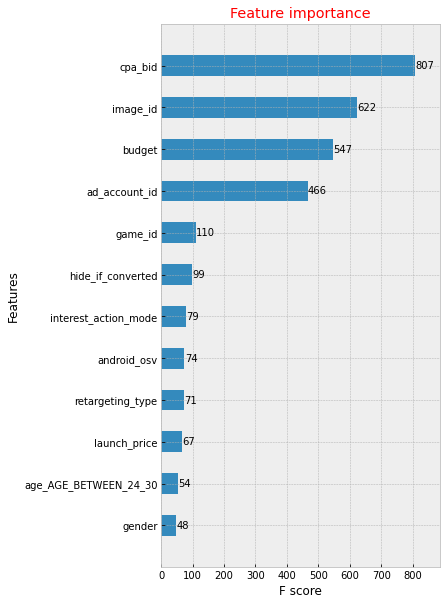

In [47]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(5, 10))
ax.set_title('Feature Importance', fontsize=12, color='r')
plot_importance(xgb_model, height=0.5, max_num_features=12, ax=ax)
plt.show()

### RF

In [48]:
rf_model = MLA[1]

In [49]:
rf_model = rf_model.fit(X_train, Y_train)

/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:482: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/root/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

In [50]:
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link fo

In [51]:
y_true = Y_train
y_pred = rf_train_pred
target_names = ['class 0', 'class 1']
print("训练集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

训练集效果:
             precision    recall  f1-score   support

    class 0       0.97      1.00      0.99     26299
    class 1       0.98      0.85      0.91      4594

avg / total       0.98      0.98      0.97     30893



In [52]:
y_true = Y_test
y_pred = rf_test_pred
target_names = ['class 0', 'class 1']
print("测试集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

测试集效果:
             precision    recall  f1-score   support

    class 0       0.86      0.95      0.90     11171
    class 1       0.39      0.16      0.23      2070

avg / total       0.79      0.83      0.80     13241



### 决策树

In [53]:
dtc_model = MLA[2]

In [54]:
dtc_model.fit(X_train, Y_train)

/root/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [55]:
dtc_train_pred = dtc_model.predict(X_train)
dtc_test_pred = dtc_model.predict(X_test)

In [56]:
y_true = Y_train
y_pred = dtc_train_pred
target_names = ['class 0', 'class 1']
print("训练集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

训练集效果:
             precision    recall  f1-score   support

    class 0       0.99      1.00      1.00     26299
    class 1       1.00      0.96      0.98      4594

avg / total       0.99      0.99      0.99     30893



In [57]:
y_true = Y_test
y_pred = dtc_test_pred
target_names = ['class 0', 'class 1']
print("测试集效果:")
print(classification_report(y_true, y_pred, target_names=target_names))

测试集效果:
             precision    recall  f1-score   support

    class 0       0.87      0.87      0.87     11171
    class 1       0.28      0.29      0.28      2070

avg / total       0.78      0.77      0.78     13241



## 规则输出
* XGB提取决策规则
* RF提取决策规则

In [58]:
import re

### XGB规则
* 可视化决策树图

In [59]:
# xgb_model.get_booster().dump_model('./xgb_model.txt', with_stats=True)

In [60]:
# with open('xgb_model.txt', 'r') as f:
#     lines = f.readlines()

In [61]:
# digraph = xgboost.to_graphviz(xgb_model, num_trees=99)
# digraph.format = 'png'
# digraph.view('./plan_xgb')

'./plan_xgb.png'

### 决策树规则

* 可视化 if else 代码

In [62]:
fea_names = df.drop(['label'], axis=1).columns.to_list()
tar_names = ['bad_plan', 'good_plan']

In [63]:
tree_to_code(dtc_model, fea_names, tar_names)

feature_name: ['budget', 'platform', 'budget', 'inventory_type_INVENTORY_TOMATO_NOVEL', 'budget', 'game_id', 'cpa_bid', 'cpa_bid', 'deep_bid_type', 'image_id', 'undefined!', 'cpa_bid', 'undefined!', 'hide_if_converted', 'auto_extend_enabled', 'undefined!', 'inventory_type_INVENTORY_VIDEO_FEED', 'label_ids_9', 'image_id', 'undefined!', 'image_id', 'image_id', 'image_id', 'cpa_bid', 'ac_4G', 'undefined!', 'image_id', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'label_ids_0', 'undefined!', 'undefined!', 'undefined!', 'inventory_type_INVENTORY_FEED', 'undefined!', 'image_id', 'image_id', 'retargeting_type', 'image_id', 'undefined!', 'cpa_bid', 'undefined!', 'undefined!', 'undefined!', 'undefined!', 'label_ids_2', 'label_ids_-', 'image_id', 'ac_WIFI', 'undefined!', 'ad_account_id', 'undefined!', 'ad_account_id', 'undefined!', 'ad_account_id', 'undefined!', 'undefined!', 'image_id', 'ac_4G', 'undefined!', 'ad_account_id', 'u

* 可视化决策树图

In [64]:
dot_data = tree.export_graphviz(dtc_model, out_file=None, feature_names=fea_names, class_names=target_names,
                                filled=True,
                                rounded=True,
                                )
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("code.pdf")

True

In [65]:
df.drop(['label'], axis=1).columns.to_list()

['ad_account_id',
 'game_id',
 'smart_bid_type',
 'hide_if_exists',
 'budget',
 'delivery_range',
 'adjust_cpa',
 'hide_if_converted',
 'flow_control_mode',
 'cpa_bid',
 'auto_extend_enabled',
 'gender',
 'platform',
 'launch_price',
 'android_osv',
 'location_type',
 'retargeting_type',
 'ios_osv',
 'interest_action_mode',
 'action_days',
 'deep_bid_type',
 'image_id',
 'inventory_type_INVENTORY_AWEME_FEED',
 'inventory_type_INVENTORY_AWEME_SEARCH',
 'inventory_type_INVENTORY_FEED',
 'inventory_type_INVENTORY_HOTSOON_FEED',
 'inventory_type_INVENTORY_SEARCH',
 'inventory_type_INVENTORY_TOMATO_NOVEL',
 'inventory_type_INVENTORY_UNION_SLOT',
 'inventory_type_INVENTORY_UNION_SPLASH_SLOT',
 'inventory_type_INVENTORY_VIDEO_FEED',
 'inventory_type_UNION_BOUTIQUE_GAME',
 'age_AGE_ABOVE_50',
 'age_AGE_BETWEEN_18_23',
 'age_AGE_BETWEEN_24_30',
 'age_AGE_BETWEEN_31_40',
 'age_AGE_BETWEEN_41_49',
 'label_ids_,',
 'label_ids_-',
 'label_ids_0',
 'label_ids_1',
 'label_ids_2',
 'label_ids_3',
 'la